connected paths


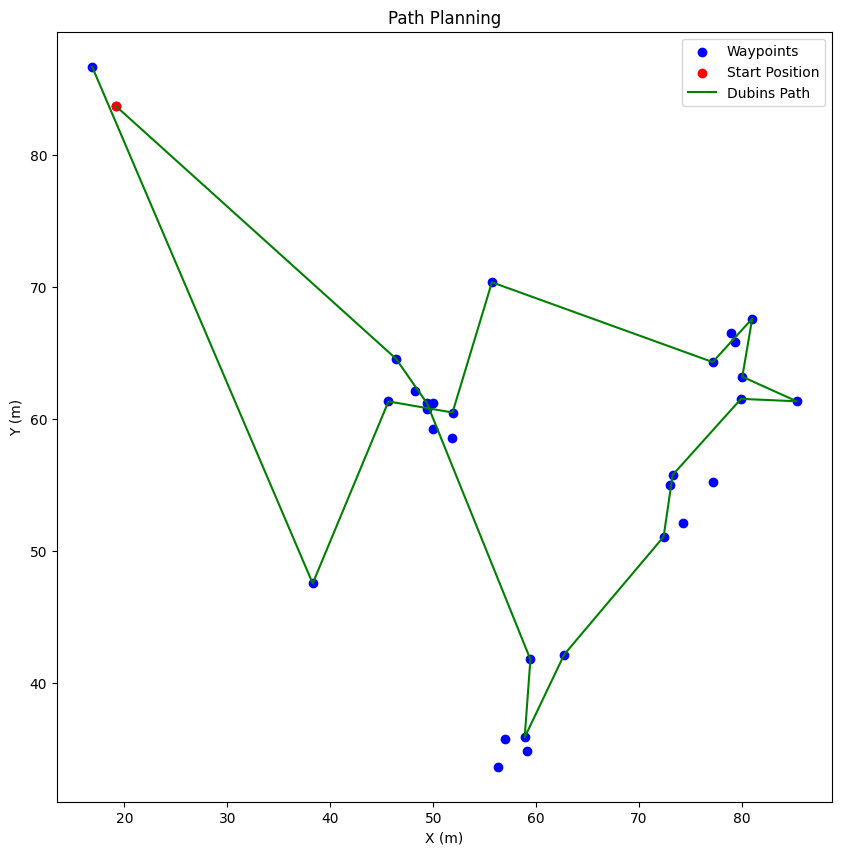

path debiuns


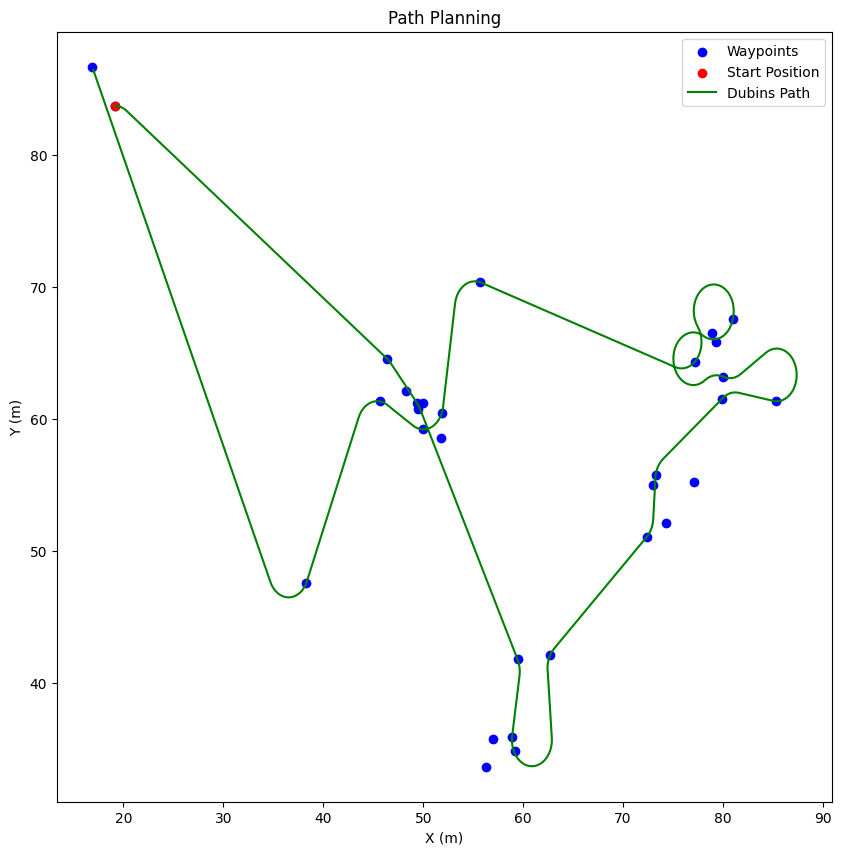

Path Length: 253.64 meters
Path Time: 253.64 seconds


In [199]:

import math
import numpy as np
import matplotlib.pyplot as plt
import math
from state_validity_checker import StateValidityChecker
from rrt_star_dubins import RRT as RRT_DUBINS
import numpy as np
import matplotlib.pyplot as plt
import math
# from dubins import path_sample
from dubins import shortest_path
import networkx as nx
from scipy.spatial import distance_matrix
import dubins
from scipy.spatial import distance
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.patches as patches

class PathPlanner:
    def __init__(self, area_size=20, num_points=10, cluster_percentage=0.8, cluster_std=3, 
                 min_turning_radius=2 , k_nearest_neighbors=20 ):
        
        '''Initialize the PathPlanner object.'''
        self.area_size = area_size
        self.num_points = num_points
        self.cluster_percentage = cluster_percentage
        self.cluster_std = cluster_std
        self.min_turning_radius = min_turning_radius
        self.robot_start_pos = None
        self.waypoints = None
        self.path_length = None
        self.path_time = None
        self.k_nearest_neighbors = 50
        # Initialize graph
        self.G = nx.Graph()
        self.path = []
        self.dubins_path = []
        self.obstacle_list = None
        self.rect_width = 4
        self.rect_height = 10

        self.svc = StateValidityChecker(area_size)
        self.rrt = RRT_DUBINS(self.svc ,30 ,100, 1 ,self.area_size ,self.min_turning_radius)

    def generate_random_points(self):
        '''Generate random waypoints in the area'''
        self.waypoints = np.random.uniform(0, self.area_size, (self.num_points, 2))


    def add_clusters(self):
        '''Add clusters of waypoints around specific points'''
        num_clusters = int(self.num_points * self.cluster_percentage)
        cluster_indices = np.random.choice(range(self.num_points), num_clusters, replace=False)

        for idx in cluster_indices:
            num_plants = np.random.randint(2,10)
            cluster_center = self.waypoints[idx]
            plants_x = np.random.normal(cluster_center[0], self.cluster_std, num_plants)
            plants_y = np.random.normal(cluster_center[1], self.cluster_std, num_plants)
            cluster_points = np.column_stack((plants_x, plants_y))
            self.waypoints = np.concatenate((self.waypoints, cluster_points))
        self.svc.set( [] )

    def assign_start_position(self):
        '''Assign a random start position for the robot'''
        self.robot_start_pos = np.random.uniform(0, self.area_size, 2)
 
    def dubins_path_length(self, start, end, turning_radius):
        '''Calculate the length of the Dubins path between two points'''
        
        samples = self.calculate_dubins_path(start, end)
        path_length = 0
        if len(samples)>2:
            for i in range(len(samples) - 2):
                 path_length = sum(distance.euclidean(samples[i][:2], samples[i+1][:2]) for i in range(len(samples)-1))
           
            return path_length
        
        return float('inf')  # Return a large number if path is infeasible
        
    def calculate_dubins_path(self, start, end):
        '''Calculate the Dubins path between two points'''
        angle  = math.atan2(end[1] - start[1],end[0]
                                           - start[0])
        # add orientation to the  gola waypoints relative to the start
        if len(end) <3:
            end = [end[0], end[1], angle]
       
        configurations = (start[0], start[1], start[2]), (end[0], end[1], end[2])
        path = shortest_path(configurations[0], configurations[1],self.min_turning_radius)
        samples = path.sample_many(0.3)
        
        return np.array(samples[0])

    
    def calculate_angle(self,current_waypoint, next_waypoint):
    # Calculate the direction to the waypoint
        direction_to_waypoint = math.atan2(next_waypoint[1] - current_waypoint[1],next_waypoint[0]
                                           - current_waypoint[0])
        current_angle = 0 # Assuming the robot is facing in the positive x-direction
        # Calculate the angle between the robot's heading and the direction to the waypoint
        angle = math.degrees(direction_to_waypoint - current_angle)

        # Normalize the angle to the range [-180, 180]
        angle = (angle + 180) % 360 - 180

        return angle
    def is_feasible(self, current_waypoint, next_waypoint):
        '''Check if the Dubins path between two waypoints is feasible'''
        # Calculate the distance to the waypoint
        distance = math.sqrt((next_waypoint[1]- current_waypoint[1])**2 + (next_waypoint[0] - current_waypoint[0])**2)
        distance2= np.linalg.norm(next_waypoint[:2]  - current_waypoint[:2])
        angle = self.calculate_angle(current_waypoint, next_waypoint)
       
       # Check if the distance is greater than the minimum turning radius 
        if distance > 2*self.min_turning_radius  :
            return True
        else:
            return False
    
    def calculate_path_length(self, path):
        
        self.path_length = 0
        for i in range(len(path) - 2):
           
            self.path_length += np.linalg.norm(path[i + 1] - path[i])
      
        self.path_time = self.path_length / 1  # Assuming constant velocity of 1 m/s

 
    def add_nodes(self, nodes):

        # Add nodes to the graph
        self.waypoints = np.insert(self.waypoints, 0, self.robot_start_pos, axis=0)  # Insert start position as the first node       
        for i, node in enumerate(self.waypoints):
            self.G.add_node(i, pos=(node[0], node[1]))
    def add_edges(self):
        # Add edges to the graph with Dubins path lengths
        for i in range(len(self.waypoints)):
            for j in range(i + 1, len(self.waypoints)):
                start = self.waypoints[i]
                end = self.waypoints[j]
                
                path_length = self.dubins_path_length(start, end, self.min_turning_radius)
                
                if path_length < float('inf'):
                    self.G.add_edge(i, j, weight=path_length)
    
    def add_edges_kdt(self):
    # Add edges to the graph with Dubins path lengths
        waypoints = self.waypoints.copy()
        # Build a KD-tree from the waypoints
        tree = KDTree(waypoints)

        for i, start in enumerate(waypoints , ):
            # Find the indices of the k nearest neighbors of the start waypoint
            _, indices = tree.query(start, k=min(self.k_nearest_neighbors, len(self.waypoints)))

            for j in indices:
                # Skip if the neighbor is the start waypoint itself
                if j == i :
                    continue

                end = waypoints[j]
                path_length = np.linalg.norm(start - end)   

                # print("path_length ",start ,end , path_length, "is_reachable ", is_reachable    )
                if path_length < float('inf')  :
                    # print("added")
                    self.G.add_edge(i, j, weight=path_length)
                else :
                    continue
                   
    def remove_edges(self):
        # Convert the waypoints to a list for easy manipulation
        self.waypoints = self.waypoints.tolist()
        # Check each waypoint
        for waypoint in self.waypoints:
            # If the waypoint is the same as the start position
            if np.array_equal(waypoint, self.robot_start_pos):
                # Remove the waypoint from the list
                self.waypoints.remove(waypoint)
        # Convert the waypoints back to a numpy array
        self.waypoints = np.array(self.waypoints)

    def find_optimal_path(self):
        # Solve the Traveling Salesman Problem (TSP) with fixed start
        tsp_path = nx.approximation.traveling_salesman_problem(self.G, cycle=False)
        # Adjust the path to start from the specific start point
        start_idx = tsp_path.index(0)
        ordered_tsp_path = tsp_path[start_idx:] + tsp_path[:start_idx]
        # Extract the waypoints in the order determined by the TSP path
        ordered_waypoints = [self.waypoints[node] for node in ordered_tsp_path]
        return ordered_waypoints
    
    def dubins_path_planner(self):
        '''Plan the Dubins path between waypoints in the optimal path. '''
        ordered_waypoints = self.find_optimal_path()
        # add orientationn to the waypoints
        ordered_waypoints = np.insert(ordered_waypoints, 2, 0, axis=1)
        ordered_waypoints = np.array(ordered_waypoints)
        self.dubins_path = []
        self.path = [ordered_waypoints[0]]
        j = 0
        i = 0
        while i < len(ordered_waypoints) - 1:
            is_feasible = self.is_feasible(ordered_waypoints[i], ordered_waypoints[i + 1])
            if is_feasible:
                angle = math.atan2(ordered_waypoints[i+1][1] - ordered_waypoints[i][1], 
                                           ordered_waypoints[i+1][0] - ordered_waypoints[i][0])
                # new_db_path , new_path = self.rrt.compute_path(ordered_waypoints[i], ordered_waypoints[i + 1])
                # self.path.extend(new_path)
                # self.dubins_path.extend(new_db_path)
                self.path.append(ordered_waypoints[i + 1]) 
                ordered_waypoints[i + 1][2] = angle
                self.dubins_path.extend(self.calculate_dubins_path(ordered_waypoints[i], ordered_waypoints[i + 1]))
                j += 1
                i += 1
            else:
                j = i + 1
                while not is_feasible and j < len(ordered_waypoints) - 1:
                    # Find the next feasible waypoint
                    j += 1
                    is_feasible = self.is_feasible(ordered_waypoints[i], ordered_waypoints[j])
                    
                    if is_feasible:
                        # include obstacle avoidance
                        # new_db_path , new_path = self.rrt.compute_path(ordered_waypoints[i], ordered_waypoints[i + 1])
                        # self.path.extend(new_path)
                        # self.dubins_path.extend(new_db_path)
                        angle = math.atan2(ordered_waypoints[j][1] - ordered_waypoints[i][1], 
                                           ordered_waypoints[j][0] - ordered_waypoints[i][0])
                        
                        ordered_waypoints[j][2] = angle
                        self.path.append(ordered_waypoints[j] )
                        self.dubins_path.extend(self.calculate_dubins_path(ordered_waypoints[i], ordered_waypoints[j]))
                        
                i = j
        # Convert the Dubins path to a numpy array
        self.dubins_path = np.array(self.dubins_path)
        return self.dubins_path
            



    def plot_path(self,path):
        '''Plot the waypoints and the Dubins path'''
        # print("path ", path )
        x_coords = [point[0] for point in path]
        y_coords = [point[1] for point in path]
        plt.figure(figsize=(10, 10))
        plt.scatter(self.waypoints[:, 0], self.waypoints[:, 1], color='blue', label='Waypoints')
        plt.scatter(self.robot_start_pos[0], self.robot_start_pos[1], color='red', label='Start Position')
        plt.plot(x_coords, y_coords, color='green', label='Dubins Path')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Path Planning')
        plt.legend()
        # plt.grid(True)
        plt.show()
    def cluster_waypoints(self):
        '''Cluster waypoints into rectangular clusters and calculate their orientation'''
        # Use DBSCAN for clustering
        db = DBSCAN(eps=10, min_samples=2).fit(self.waypoints)
        labels = db.labels_

        unique_labels = set(labels)
        clustered_waypoints = []
        print("unique_labels ", unique_labels)
        for label in unique_labels:
            if label == -1:  # Noise points
                continue
            class_member_mask = (labels == label)
            cluster = self.waypoints[class_member_mask]
            print("cluster ", cluster)

            # Fit a rectangle to the cluster using PCA
            pca = PCA(n_components=2)
            pca.fit(cluster)
            width, height = self.rect_width, self.rect_height
            rect_center = np.mean(cluster, axis=0)
            angle = np.arctan2(pca.components_[0, 1], pca.components_[0, 0])

            # Generate the rectangular cluster waypoints
            rect_points = self.generate_rectangle_points(rect_center, width, height, angle)
            clustered_waypoints.extend(rect_points)
            print("clustered_waypoints ", clustered_waypoints)
               # Draw rectangle for visualization
            self.draw_rectangle(rect_center, width, height, angle)

        # self.waypoints = np.array(clustered_waypoints)
    def generate_rectangle_points(self, center, width, height, angle):
        '''Generate points for a rectangle given its center, width, height, and orientation'''
        rect_points = []
        for dx in [-width / 2, width / 2]:
            for dy in [-height / 2, height / 2]:
                x = center[0] + dx * np.cos(angle) - dy * np.sin(angle)
                y = center[1] + dx * np.sin(angle) + dy * np.cos(angle)
                rect_points.append([x, y])
        return rect_points
    def draw_rectangle(self, center, width, height, angle):
        '''Draw a rectangle for visualization'''
        fig, ax = plt.subplots()
        c, s = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([[c, -s], [s, c]])
        
        rectangle = np.array([
            [-width / 2, -height / 2],
            [width / 2, -height / 2],
            [width / 2, height / 2],
            [-width / 2, height / 2]
        ])
        
        rotated_rectangle = np.dot(rectangle, rotation_matrix) + center
        rect = patches.Polygon(rotated_rectangle, closed=True, fill=False, edgecolor='r')
        ax.add_patch(rect)
        
        ax.set_xlim(0, self.area_size)
        ax.set_ylim(0, self.area_size)
        plt.scatter(self.waypoints[:, 0], self.waypoints[:, 1], color='blue')
        plt.scatter(self.robot_start_pos[0], self.robot_start_pos[1], color='red', label='Start Position')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Clustered Waypoints with Rectangular Coverage Areas')
        plt.legend()
        plt.grid(True)
        plt.show()
    def execute(self):
        self.generate_random_points()
        self.add_clusters()
        self.assign_start_position()
        self.add_nodes(self.waypoints)
        self.add_edges_kdt()
        # self.cluster_waypoints()
        ordered_waypoint = self.find_optimal_path()
       
        dubins_path = self.dubins_path_planner()[: , 0:2] # Extract only the x and y coordinates
        print("connected paths")
        self.plot_path(self.path);
        print("path debiuns")
        self.plot_path(dubins_path);
        self.calculate_path_length(dubins_path)
        print(f"Path Length: {self.path_length:.2f} meters")
        print(f"Path Time: {self.path_time:.2f} seconds")
   

if __name__ == "__main__":

    area_size = 100
    num_points = 8
    cluster_percentage = 0.6
    cluster_std = 3
    min_turning_radius = 2
    k_nearest_neighbors = 50
    path_planner = PathPlanner( area_size, num_points, cluster_percentage, cluster_std, min_turning_radius , k_nearest_neighbors)
    path_planner.execute()


